In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

<u>2.1) BENCHMARKS</u> 

In [2]:
def B_S_price(S, K, T, r, sigma, option_type):
    """
    option_type : Type of option ('call' or 'put')

    """
    # Compute d1 and d2
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    if option_type.lower() == 'call':
        # call option price formula
        price = S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    elif option_type.lower() == 'put':
        # put option price formula
        price = K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Please use 'call' or 'put'.")

    return price

In [3]:
#Example
if __name__ == "__main__":

    S = 100  # current stock price
    K = 100  # strike price
    T = 1    # maturity time (1 year)
    r = 0.05 # risk free rate (5%)
    sigma = 0.2  # volatility (20%)


    C = B_S_price(S, K, T, r, sigma, 'call')
    P = B_S_price(S, K, T, r, sigma, 'put')

    print(f"Call price: {C:.2f}")
    print(f"Put price: {P:.2f}")

Call price: 10.45
Put price: 5.57


<u>2.2) SOLVING THE PDE</u> 

The bounds for $x$  are derived to ensure coverage of the likely price paths of the underlying asset. The boundaries are defined as:

$$
x_{\text{min/max}} = \left( r - \frac{1}{2}\sigma^2 \right)T \pm k\sigma\sqrt{T}
$$

where:
- $ \left( r - \frac{1}{2}\sigma^2 \right)T $ represents the drift component, accounting for the expected growth of the logarithm of the asset price over time \( T \).

- $ k\sigma\sqrt{T} $ represents the diffusion component, covering potential effects of volatility over time.
- The choice of $ k = 3 $ or $ k = 4 $ ensures the range includes almost all probable outcomes for the asset price, corresponding to 99.7% confidence for $ k = 3 $ (three standard deviations).


In [8]:
def solve_B_S_pde(S0, K, T, r, sigma, ntime, nspace, option_type='call'):
    """
    Solve the Black-Scholes PDE using explicit FDM

    Returns:
    np.ndarray: Option prices at time zero for all underlying asset prices steps
    """
    # Underlying asset price and time grids
    xmin = np.log(S0) - 4 * sigma * np.sqrt(T)
    xmax = np.log(S0) + 4 * sigma * np.sqrt(T)
    x = np.linspace(xmin, xmax, nspace)
    dx = x[1] - x[0]
    dt = T / ntime

    # stability property
    C = sigma**2 * dt / dx**2
    if C >= 1:
        raise ValueError("The scheme is unstable. Reduce dt or increase dx.")

    # Initialize the option price grid
    h = np.zeros((ntime + 1, nspace))

    # Terminal condition: Payoff at T
    if option_type == 'call':
        h[-1, :] = np.maximum(np.exp(x) - K, 0)
    elif option_type == 'put':
        h[-1, :] = np.maximum(K - np.exp(x), 0)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    # Backward iteration in time
    for j in range(ntime - 1, -1, -1):
        for i in range(1, nspace - 1):
            h[j, i] = h[j + 1, i] + dt * (
                0.5 * sigma**2 * (h[j + 1, i + 1] - 2 * h[j + 1, i] + h[j + 1, i - 1]) / dx**2 +
                (r - 0.5 * sigma**2) * (h[j + 1, i + 1] - h[j + 1, i - 1]) / (2 * dx) -
                r * h[j + 1, i]
            )

        # Boundary conditions
        h[j, 0] = h[j+1, 0] + dt * (r - 0.5 * sigma**2) * (h[j + 1, 1] - h[j + 1, 0]) / (dx) - r * h[j + 1, 0]
        h[j, -1] = h[j+1, -1] + dt * (r - 0.5 * sigma**2) * (h[j + 1, -1] - h[j + 1, -2]) / (dx) - r * h[j + 1, -1]

    # Interpolate to find the price at S0
    S = np.exp(x)
    return np.interp(S0, S, h[0, :])


In [9]:
# Here is an example of the use of the function above 
if __name__ == "__main__":
    # Parameters
    S0 = 100  # Initial stock price
    K = 100   # Strike price
    T = 1     # Time to maturity
    r = 0.05  # Risk-free rate
    sigma = 0.2  # Volatility
    ntime = 1000  # Time steps
    nspace = 100  # Spatial steps

    # Solve PDE for a call option
    C_2 = solve_B_S_pde(S0, K, T, r, sigma, ntime, nspace, 'call')
    print(f"Call Option Price: {C_2:.2f}")


Call Option Price: 10.45


<u>Comparison with the Black-Sholes price :</u>

Consistency Check :
The numerical solution from the PDE (finite difference method) should match the analytical Black-Scholes formula, especially as the spatial and temporal grid resolutions are refined (i.e., increasing 𝑛𝑡𝑖𝑚𝑒 and 𝑛𝑠𝑝𝑎𝑐𝑒).

Deviations occur due to numerical errors, primarily because of discretization and the boundary assumptions.

<u>Discussion of the impact of C:</u> 

-If 𝐶 is too small:

    -Smaller 𝛿𝑡 or larger 𝛿𝑥 results in slower convergence.
    -Computationally expensive because more time steps are required to propagate the solution backward.
    
-If 𝐶 is too large:

    -Violates the stability condition (𝐶≥1), leading to divergence or oscillatory solutions.
    
-For smaller 𝐶, numerical solutions converge closely to the Black-Scholes price but require more computational resources.

-Larger 𝐶 values introduce instability and deviations.

-The optimal balance lies in choosing 𝐶 just below 1 while considering the available computational power.


<u>2.3) DIFFERENT PAYOFFS:</u> 

In [10]:
def solve_pde_with_normalized_payoff(S0, T, r, sigma, ntime, nspace, payoff_type):
    """
    Solve Black-Scholes PDE for normalized payoffs with K = 1.

    Returns:
    np.ndarray: Option prices at time zero for all spatial steps
    np.ndarray: Stock prices corresponding to the grid
    """
    # Define the underlying asset price grid
    xmin = np.log(S0) - 4 * sigma * np.sqrt(T)
    xmax = np.log(S0) + 4 * sigma * np.sqrt(T)
    x = np.linspace(xmin, xmax, nspace)
    S = np.exp(x)  # Stock prices corresponding to the grid

    # Initialize the payoff with K = 1
    K = 1
    if payoff_type == 'call':
        payoff = np.maximum(S - K, 0)  # x - 1
    elif payoff_type == 'put':
        payoff = np.maximum(K - S, 0)  # 1 - x
    elif payoff_type == 'binary':
        payoff = np.where(S >= K, 1, 0)
    else:
        raise ValueError("Invalid payoff type. Use 'call', 'put', or 'binary'.")

    # Reuse the existing solve_black_scholes_pde function
    h = np.zeros((ntime + 1, nspace))
    h[-1, :] = payoff  # Set terminal condition
    dx = x[1] - x[0]
    dt = T / ntime

    for j in range(ntime - 1, -1, -1):
        for i in range(1, nspace - 1):
            h[j, i] = h[j + 1, i] + dt * (
                0.5 * sigma**2 * (h[j + 1, i + 1] - 2 * h[j + 1, i] + h[j + 1, i - 1]) / dx**2 +
                (r - 0.5 * sigma**2) * (h[j + 1, i + 1] - h[j + 1, i - 1]) / (2 * dx) -
                r * h[j + 1, i]
            )

        # Boundary conditions
        h[j, 0] = h[j+1, 0] + dt * (r - 0.5 * sigma**2) * (h[j + 1, 1] - h[j + 1, 0]) / (dx) - r * h[j + 1, 0]
        h[j, -1] = h[j+1, -1] + dt * (r - 0.5 * sigma**2) * (h[j + 1, -1] - h[j + 1, -2]) / (dx) - r * h[j + 1, -1]

    return h[0, :], S


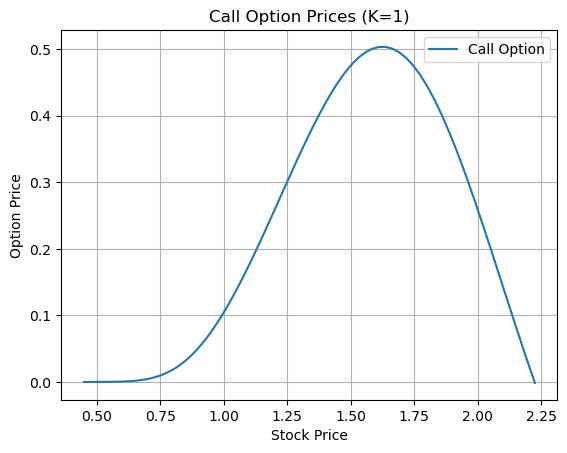

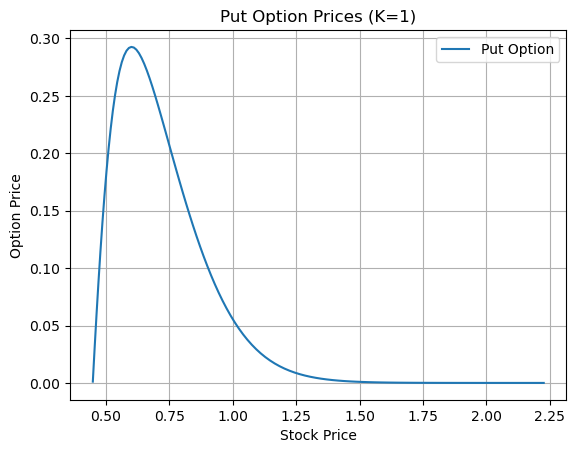

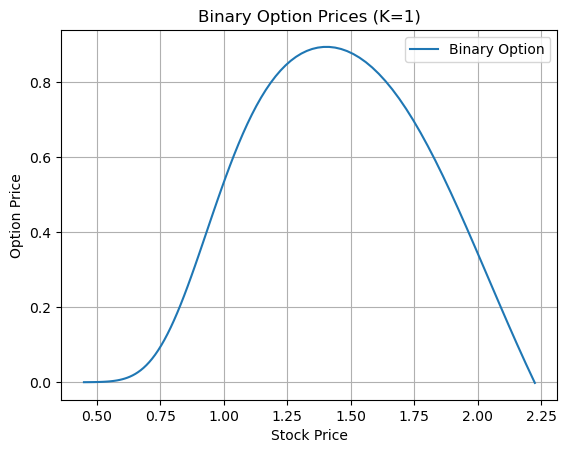

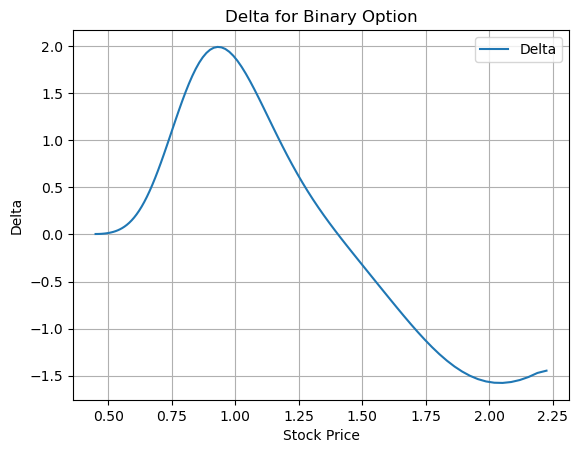

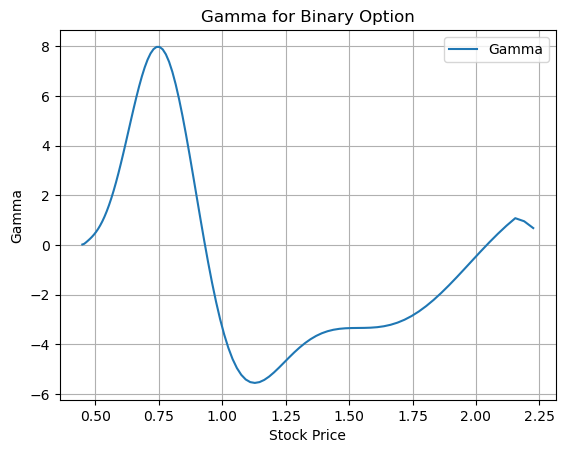

In [11]:
# Example and plot
if __name__ == "__main__":
    S0 = 1  # Initial stock price (arbitrary)
    T = 1   # maturity time (arbitrary)
    r = 0.05  # Risk free rate (arbitrary)
    sigma = 0.2  # Volatility (arbitrary)
    ntime = 1000  # Number of time steps (arbitrary)
    nspace = 100  # Number of ua price steps (arbitrary)

    # Solve for each payoff type
    for payoff_type in ['call', 'put', 'binary']:
        prices, S = solve_pde_with_normalized_payoff(S0, T, r, sigma, ntime, nspace, payoff_type)
        plt.figure()
        plt.plot(S, prices, label=f'{payoff_type.capitalize()} Option')
        plt.title(f'{payoff_type.capitalize()} Option Prices (K=1)')
        plt.xlabel('Stock Price')
        plt.ylabel('Option Price')
        plt.legend()
        plt.grid()
        plt.show()

    # delta and gamma for binary option
    binary_prices, S = solve_pde_with_normalized_payoff(S0, T, r, sigma, ntime, nspace, 'binary')
    delta = np.gradient(binary_prices, S)  # Numerical derivative for Delta
    gamma = np.gradient(delta, S)  # Numerical derivative for Gamma

    # Plot delta
    plt.figure()
    plt.plot(S, delta, label='Delta')
    plt.title('Delta for Binary Option')
    plt.xlabel('Stock Price')
    plt.ylabel('Delta')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot gamma
    plt.figure()
    plt.plot(S, gamma, label='Gamma')
    plt.title('Gamma for Binary Option')
    plt.xlabel('Stock Price')
    plt.ylabel('Gamma')
    plt.legend()
    plt.grid()
    plt.show()
